# IRL for PdM
- V.1.0 04-Aug-2024: First version
- V.2.0 07-Aug-2024: New milling env.: Drop Time observation. All force and vibration axes (x, y, z) 

In [56]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
# Custom libraries
from MT_environment import MillingTool_Env
from utilities import downsample, tool_wear_data

In [57]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = 0.12
SAMPLING_RATE = 1
ADD_NOISE = 0

EPISODES = 4000
BATCH_SIZE = 16
SAMPLE_DEMONSTRATIONS = 100
EVALUATION_ROUNDS = 10
TENSOR_BOARD = True

PRETRAINED_MODEL = True # If True load model. If False save as model_file 
MODEL_FILE = 'Expert_Model_PPO' 
LOG_PATH = 'D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/'
# LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/


- Down-sampling. Input data records: 1000. Sampling rate: 1. Expected rows 1000.    Down-sampled to 1000 rows.


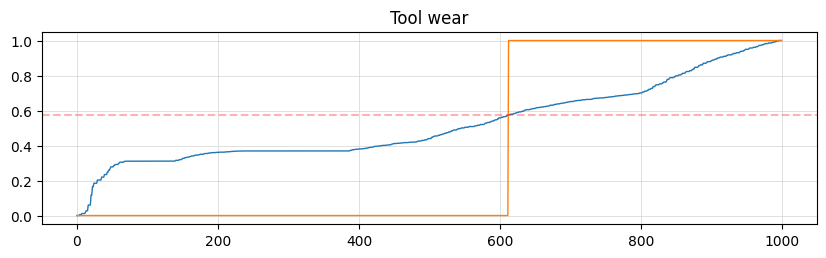

Tool failure RUL threshold at time 950 is 0.050


In [58]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')

## 1. Predictive maintenance environment

In [59]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MillingTool_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

mt_env = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(mt_env)


 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.050


In [60]:
mt_env.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 1000


## 2. The "Human" Expert

In [61]:
if TENSOR_BOARD:
    expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
else:
    expert_ppo = PPO('MlpPolicy', env=mt_env)

if not PRETRAINED_MODEL:
    print(f'- Training a *NEW* Expert model...')
    expert_ppo.learn(EPISODES)
    print(f'- Saving Expert model in {MODEL_FILE}')
    expert_ppo.save(MODEL_FILE)
else:
    print(f'- Loading pre-tranined Expert model from {MODEL_FILE}')
    expert_ppo = PPO.load(MODEL_FILE)

- Saving Expert model in Expert_Model_PPO


In [62]:
# if TENSOR_BOARD:
#     expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
# else:
#     expert_a2c = A2C('MlpPolicy', env=mt_env)

# expert_a2c.learn(EPISODES)

In [63]:
reward_ppo, _ = evaluate_policy(expert_ppo, mt_env, 5)
print(f'PPO Expert reward: {reward_ppo:4.2f}')

# reward_a2c, _ = evaluate_policy(expert_a2c, mt_env, 20)
# print(f'A2C Expert reward: {reward_a2c:4.2f}')

PPO Expert reward: 4180.78


## 3. Train the student by applying IRL - using expert demonstrations

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [64]:
# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'records':records, 'rul_threshold':rul_threshold}

mt_venv = make_vec_env(
    'custom/MillingToolEnv-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
)


 -- Milling tool environment initiatlized. Potential records 0. RUL threshold 0.000

 -- Milling tool environment initiatlized. Potential records 1000. RUL threshold 0.050


### Add tool wear data
- IMPORTANT -- note how a vectorized env. methd is called
- NOT like this >>  mt_venv.tool_wear_data(df_train)

In [65]:
# Add tool wear data
# IMPORTANT -- note how a vectorized env. methd is called
# NOT like this >>  mt_venv.tool_wear_data(df_train)
mt_venv.env_method('tool_wear_data', df_train)


 - Milling tool environment: Tool wear data updated: 1000


[None]

In [ ]:
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

demonstrations = rollout.flatten_trajectories(rollouts)

In [ ]:
import matplotlib.pyplot as plt
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(demonstrations.acts[n])
    obsvs.append(demonstrations.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

## 3.2 Set up IRL algorithm
- Set up our behavior cloning algorithm
- Compute rewards before showing expert demonstrations

In [ ]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

if TENSOR_BOARD:
    # Set new logger
    tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
    new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu',
        custom_logger = new_logger_irl)
else:
    bc_trainer = bc.BC(
        observation_space=mt_venv.observation_space,
        action_space=mt_venv.action_space,
        demonstrations=demonstrations,
        batch_size=BATCH_SIZE,
        rng=rng,
        device='cpu')

In [ ]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

## 3.3 Apply IRL - BC algo.
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm- 
Compute reward and compares befor/aftere showing expert demonstrations

In [ ]:
bc_trainer.train(n_epochs=1)

In [ ]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Expert performance:             {reward_ppo:5.3f}')
print(f'Apprentice performance: Before: {reward_before_training:5.3f}')
print(f'                        After:  {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

## Results
```
-------------------------------------------------------------------------------------
| Date-time             | Episodes | Expert   | Apprentice-before |Apprentice-after |
-------------------------------------------------------------------------------------
| 07-Aug-2024  20:51:01 | 4000     | 4176.156 | 147.070           | 4180.070        |
| 07-Aug-2024  21:53:24 |  400     | 4176.033 | 536.258           | 4174.686        |
| 07-Aug-2024  21:53:24 | 4000     | 4176.033 | 536.258           | 4174.686        |
0
```

## 3.3.b Apply IRL - SQIL algo.
- Use expert demonstrations and learn the reward function - using ## 3.3 Apply IRL (BC)
- Use expert demonstrations and learn the reward function - using Behavior Cloning algorithm
- Compute rewards and compare before/after showing expert demonstrations algorithm
- Compute rewards and compare before/after showing expert demonstrations

In [ ]:
# from imitation.algorithms import sqil
# from imitation.util import logger as imit_logger

# if TENSOR_BOARD:
#     # Set new logger
#     tmp_path_irl = f'{PATH}/tensorboard/irl_log/SQIL/'
#     new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])
    
#     sqil_trainer = sqil.SQIL(   
#         venv = mt_venv,
#         demonstrations = transitions,
#         policy='MlpPolicy',
#         # device='cpu',
#         custom_logger = new_logger_irl
#     )
# else: 
#     sqil_trainer = sqil.SQIL(   
#         venv = mt_venv,
#         demonstrations = demonstrations,
#         policy='MlpPolicy')

In [ ]:
# reward_before_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, EVALUATION_ROUNDS)

# # Note: set to 1_000_000 to obtain good results
# sqil_trainer.train(total_timesteps = EPISODES)  

# reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, EVALUATION_ROUNDS)

# print(dt_string)
# print(f'Episodes: {EPISODES}')
# print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')